In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
df = pd.read_pickle('data/prop_data_gap_12_4_1.pkl')
df

,rep,exp,start,time_win,max_gap,CC,ants,partition,MOD,DEN,wDEN,DIA,wDIA,RAD,wRAD,DEH,wDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,43200,5,1,177,3,0.277676,0.964368,0.003132,2,0.008075,1,0.004761,7.919433,8876.307392,0.012953
1,13,DEHa,2021-09-12 09:00:00,3600,5,1,177,9,0.503127,0.435927,0.003632,3,0.09807,2,0.054673,33.491666,1290.363806,0.003218
2,13,DEHa,2021-09-12 10:00:00,3600,5,1,177,9,0.582983,0.410118,0.003628,3,0.072419,2,0.042489,30.520181,1602.451913,0.002856
3,13,DEHa,2021-09-12 11:00:00,3600,5,1,177,7,0.41317,0.49801,0.003255,2,0.237292,2,0.171429,32.276024,915.816669,0.006928
4,13,DEHa,2021-09-12 12:00:00,3600,5,1,177,8,0.542923,0.387969,0.002959,2,0.105196,2,0.054731,30.739462,1164.523006,0.004107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,56,DENb,2021-12-20 19:00:00,3600,20,1,172,7,0.432948,0.491976,0.007604,2,0.034613,2,0.018569,32.454009,1627.223116,0.009796
5037,56,DENb,2021-12-20 20:00:00,3600,20,1,172,6,0.447648,0.492928,0.007966,2,0.032186,2,0.017865,30.021452,1950.482658,0.010871
5038,56,DENb,2021-12-20 09:00:00,14400,20,1,172,5,0.242208,0.832041,0.008077,2,0.009572,1,0.006048,21.701276,5845.620486,0.017827
5039,56,DENb,2021-12-20 13:00:00,14400,20,1,172,5,0.252718,0.830409,0.008147,2,0.00811,1,0.005179,21.781153,5613.886605,0.022328


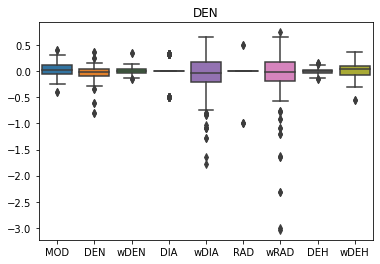

In [15]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DEN'
df_filt = df.loc[(df.time_win==3600*1) & 
                 (df.max_gap==5) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]



# ---- dataframe of relative difference---- 
p = df_filt.columns[8:]
df_rd = (df_filt[p].diff()/df_filt[p]).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(2,'start-a', list(df_filt.start.iloc[::2]))
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

boxplot = sns.boxplot(data=df_rd[p[:-1]])
fig = plt.title(exp)



In [17]:
df_filt.sort_values('start')

,rep,exp,start,time_win,max_gap,CC,ants,partition,MOD,DEN,wDEN,DIA,wDIA,RAD,wRAD,DEH,wDEH,CLS
81,15,DENb,2021-09-12 09:00:00,3600,5,1,186,7,0.428859,0.545655,0.004401,2,0.061062,2,0.031351,33.386098,1612.658668,0.004487
994,15,DENb,2021-09-12 09:00:00,3600,5,1,186,7,0.428859,0.545655,0.004401,2,0.061062,2,0.031351,33.386098,1612.658668,0.004487
995,15,DENb,2021-09-12 10:00:00,3600,5,1,186,11,0.632412,0.341412,0.00407,3,0.108149,2,0.056604,31.35293,1680.057121,0.004961
82,15,DENb,2021-09-12 10:00:00,3600,5,1,186,11,0.632412,0.341412,0.00407,3,0.108149,2,0.056604,31.35293,1680.057121,0.004961
996,15,DENb,2021-09-12 11:00:00,3600,5,1,186,8,0.536734,0.423017,0.00367,2,0.123778,2,0.064823,34.115995,1347.594663,0.005636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,56,DENa,2021-12-22 16:00:00,3600,5,1,170,7,0.513599,0.411486,0.005188,3,0.0762,2,0.038226,29.822831,1489.064654,0.010026
2266,56,DENa,2021-12-22 17:00:00,3600,5,1,170,7,0.489499,0.436547,0.004962,3,0.059908,2,0.03239,30.991603,1384.841802,0.01067
2267,56,DENa,2021-12-22 18:00:00,3600,5,1,170,7,0.498851,0.438009,0.005062,2,0.109465,2,0.081081,31.825619,1422.162223,0.008355
2268,56,DENa,2021-12-22 19:00:00,3600,5,2,170,8,0.513349,0.421175,0.004902,3,0.06545,2,0.034608,30.356565,1479.195531,0.008772
